## Data Preparation

In [30]:
import pygris
from pygris import tracts
# import geopandas as gpd
from matplotlib import pyplot as plt
import pandas as pd
import folium

Using FIPS code '09' for input 'CT'


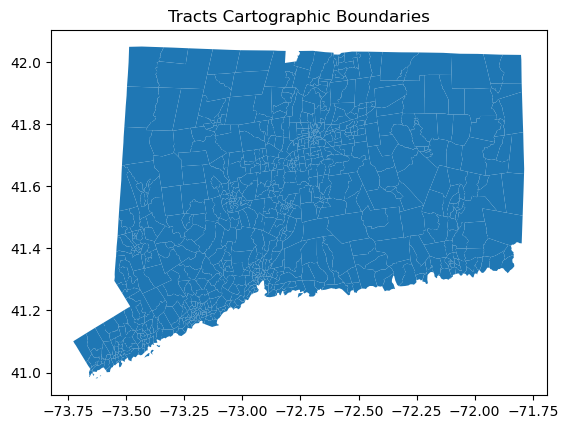

In [2]:
# Download geometry
ct_tracts = tracts(state = "CT", cb = True, cache = True, year = 2016)

# Display geometry
fig, ax = plt.subplots()
ct_tracts.plot(ax = ax)
plt.title("Tracts Cartographic Boundaries");

In [11]:
# Import tracts population data
pop = pd.read_csv("../data/population.csv")

In [23]:
# Convert data type so join key matches
ct_tracts["Geo_TRACT"] = ct_tracts["TRACTCE"].astype(int)

In [33]:
# Join attributes to geometry
tracts = ct_tracts.merge(pop, how = "inner", on='Geo_TRACT')

In [38]:
?gpd.to_crs("EPSG:4326")

Object `gpd.to_crs` not found.


In [43]:
# Project tracts
tracts = tracts.to_crs("EPSG:2234")

# Calculate area
tracts["Area"] = tracts.area

# Calculate population density
tracts["PopDensity"] = tracts["SE_A00001_001"]/tracts["Area"]


<Axes: >

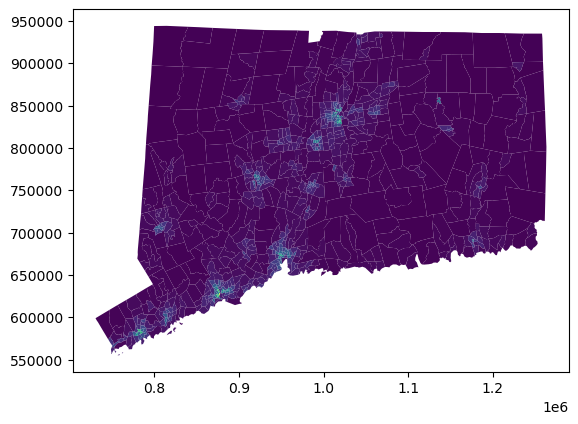

In [44]:
tracts.plot("PopDensity")